In [294]:
import torch
import torch.nn as nn
from torch.utils import data
from torchvision.models import vgg19
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np
import os

# use the ImageNet transformation
transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# define a 1 image dataset
dataset = datasets.ImageFolder(root='~/PYTORCH/data4/', transform=transform)

# define the dataloader to load that single image
dataloader = data.DataLoader(dataset=dataset, shuffle=False, batch_size=1)

In [295]:
#vgg19(pretrained=True)
from torchvision.models import VGG19_Weights

In [442]:
vgg19()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [448]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        self.vgg = vgg19(VGG19_Weights.IMAGENET1K_V1)
        self.feature_conv = self.vgg.features[:36]
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        self.classifier = self.vgg.classifier
        self.gradients = None

    def activations_hook(self, grad): # # hook for the gradients of the activations
        print(grad)
        self.gradients = grad

    def forward(self, x):
        x = self.feature_conv(x)
        h = x.register_hook(self.activations_hook)# register the hook

        x = self.max_pool(x)# apply the remaining pooling
        x = x.view((1,-1))
        x = self.classifier(x)

        return x

    def get_activations_gradient(self):# method for the gradient extraction
        return self.gradients

    def get_activations(self,x):# method for the activation extraction
        return self.feature_conv(x)



## Drawing CAM

In [449]:
# initialize the VGG model
vgg = VGG()

# set the evaluation mode
vgg.eval()

# get the image from the dataloader
img,_ = next(iter(dataloader))

# get the most likely prediction of the model
pred = vgg(img)
pred.size()

/Users/ceyhun/opt/anaconda3/envs/Dataspell_1_env/lib/python3.8/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


torch.Size([1, 1000])

In [450]:
a = vgg(img).argmax(dim=1)
a

tensor([787])

In [451]:
# get the gradient of the output with respect to the parameters of the model
pred[:, 787].backward()

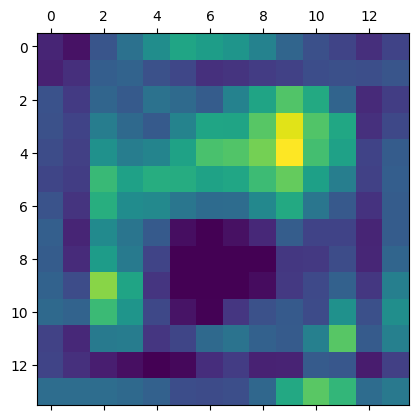

In [452]:


# pull the gradients out of the model
gradients = vgg.get_activations_gradient()

# pool the gradients across the channels
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

# get the activations of the last convolutional layer
activations = vgg.get_activations(img).detach()

# weight the channels by corresponding gradients
for i in range(512):
    activations[:, i, :, :] *= pooled_gradients[i]

# average the channels of the activations
heatmap = torch.mean(activations, dim=1).squeeze()

# relu on top of the heatmap
# expression (2) in https://arxiv.org/pdf/1610.02391.pdf
heatmap = np.maximum(heatmap, 0)

# normalize the heatmap
heatmap /= torch.max(heatmap)

# draw the heatmap
plt.matshow(heatmap.squeeze())

In [453]:
import cv2
#heatmap = heatmap.detach().numpy()
img = cv2.imread('data4/ben/kanser2.jpeg')
print('Original Dimensions : ',img.shape)
width = int(img.shape[1])
height = int(img.shape[0])
dim = (width, height)

Original Dimensions :  (630, 612, 3)


In [305]:
#

heatmap = cv2.resize(heatmap,dim)
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.6 + img
cv2.imwrite('data4/map.jpg', superimposed_img)

True

In [432]:
# use the ImageNet transformation
transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# define a 1 image dataset
dataset = datasets.ImageFolder(root='~/PYTORCH/data4/', transform=transform)

# define the dataloader to load that single image
dataloader = data.DataLoader(dataset=dataset, shuffle=False, batch_size=1)

In [433]:
from torchvision.models import DenseNet201_Weights, DenseNet, densenet201, densenet169, AlexNet, alexnet,DenseNet169_Weights
DenseNet()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [434]:
class DenseNet(nn.Module):
    def __init__(self):
        super(DenseNet, self).__init__()

        # get the pretrained DenseNet201 network
        self.densenet = densenet169(weights=DenseNet169_Weights.IMAGENET1K_V1)

        # disect the network to access its last convolutional layer
        self.features_conv = self.densenet.features[:16]

        # add the average global pool
        self.global_avg_pool = nn.AvgPool2d(kernel_size=7, stride=1)

        # get the classifier of the vgg19
        self.classifier = self.densenet.classifier

        # placeholder for the gradients
        self.gradients = None

    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad

    def forward(self, x):
        x = self.features_conv(x)

        # register the hook
        h = x.register_hook(self.activations_hook)

        # don't forget the pooling
        x = self.global_avg_pool(x)
        x = x.view((1,1664))
        x = self.classifier(x)
        return x

    def get_activations_gradient(self):
        return self.gradients

    def get_activations(self, x):
        return self.features_conv(x)

In [435]:
# initialize the VGG model
dense = DenseNet()

# set the evaluation mode
dense.eval()

# get the image from the dataloader
img, _ = next(iter(dataloader)) ####

# get the most likely prediction of the model
pred = dense(img)

In [436]:
pred

tensor([[-1.4288e-01, -2.6410e+00,  4.0346e+00,  5.8102e+00,  4.1263e+00,
          1.0403e+01,  7.8156e+00, -2.2117e+00, -5.3576e-01, -3.2957e+00,
         -4.7172e+00, -3.9980e+00,  1.4007e+00, -3.1091e+00, -7.6022e-01,
         -2.0977e+00, -6.7562e+00, -5.1478e+00, -3.4151e+00, -4.3451e+00,
         -4.5207e+00,  2.9135e-01,  1.4021e+00, -2.8490e+00,  1.7188e-01,
         -2.7339e+00, -7.7264e-01,  9.2901e-01, -6.9284e-01, -3.2968e+00,
          5.6001e-01, -6.5737e-01, -1.6367e+00, -1.0698e+00,  4.6322e-02,
          4.2307e-01,  1.8525e-02,  1.3849e+00, -8.9548e-01, -3.6973e+00,
         -3.9707e+00, -1.0382e+00, -2.9455e+00, -1.1287e+00, -2.3976e+00,
         -3.2386e+00, -2.9496e+00, -4.4504e+00, -4.1692e+00, -1.6397e+00,
         -8.2266e-01,  1.6475e+00, -7.4108e-02,  7.6922e-01, -1.2572e+00,
         -2.1610e+00, -3.1439e+00, -5.5672e-01, -7.8202e-01,  2.6771e+00,
          1.5497e+00, -3.0795e+00,  2.7627e-01,  2.7053e+00, -2.4786e-01,
          2.1400e+00,  1.9565e+00, -4.

In [437]:
pred.argmax(dim=1)

tensor([464])

In [438]:
# get the gradient of the output with respect to the parameters of the model
pred[:, 464].backward()

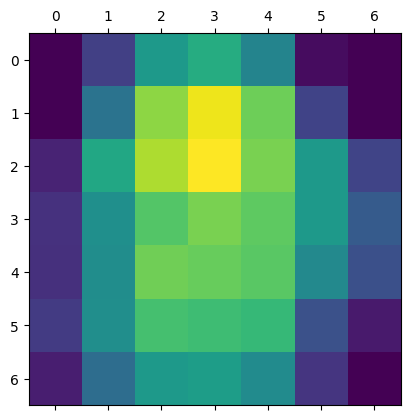

In [439]:
# pull the gradients out of the model
gradients = dense.get_activations_gradient()


# pool the gradients across the channels
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

# get the activations of the last convolutional layer
activations = dense.get_activations(img).detach()

# weight the channels by corresponding gradients
for i in range(512):
    activations[:, i, :, :] *= pooled_gradients[i]

# average the channels of the activations
heatmap = torch.mean(activations, dim=1).squeeze()

# relu on top of the heatmap
# expression (2) in https://arxiv.org/pdf/1610.02391.pdf
heatmap = np.maximum(heatmap, 0)

# normalize the heatmap
heatmap /= torch.max(heatmap)

# draw the heatmap
plt.matshow(heatmap.squeeze())

In [440]:
import cv2
heatmap = heatmap.detach().numpy()
img = cv2.imread('data4/ben/kanser2.jpeg')
print('Original Dimensions : ',img.shape)
width = int(img.shape[1])
height = int(img.shape[0])
dim = (width, height)

Original Dimensions :  (630, 612, 3)


In [441]:
heatmap = cv2.resize(heatmap,dim)
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.6 + img
cv2.imwrite('data4/map.jpg', superimposed_img)

True

In [481]:
a= torch.Tensor([[2,4,6],[1,2,3]]) ;a

tensor([[2., 4., 6.],
        [1., 2., 3.]])

In [482]:
a.requires_grad_()

tensor([[2., 4., 6.],
        [1., 2., 3.]], requires_grad=True)

In [483]:
b = a.pow(3).sum()
b

tensor(324., grad_fn=<SumBackward0>)

In [484]:
b.backward()

In [517]:
a.grad

tensor([[ 12.,  48., 108.],
        [  3.,  12.,  27.]])

In [574]:
# Inherit from Function
class LinearFunction(torch.autograd.Function):

    # Note that both forward and backward are @staticmethods
    @staticmethod
    # bias is an optional argument
    def forward(ctx, input, weight, bias=None):
        ctx.save_for_backward(input, weight, bias)

        output = input.mm(weight.t())
        print('output',output)
        print('weight',weight)
        if bias is not None:
            output += bias.unsqueeze(0).expand_as(output)
        return output

    # This function has only a single output, so it gets only one gradient
    @staticmethod
    def backward(ctx, grad_output):
        # This is a pattern that is very convenient - at the top of backward
        # unpack saved_tensors and initialize all gradients w.r.t. inputs to
        # None. Thanks to the fact that additional trailing Nones are
        # ignored, the return statement is simple even when the function has
        # optional inputs.
        print('ceyhun')
        input, weight, bias = ctx.saved_tensors
        print('input degerler', input)
        grad_input = grad_weight = grad_bias = None

        # These needs_input_grad checks are optional and there only to
        # improve efficiency. If you want to make your code simpler, you can
        # skip them. Returning gradients for inputs that don't require it is
        # not an error.
        if ctx.needs_input_grad[0]:
            grad_input = grad_output.mm(weight)
        if ctx.needs_input_grad[1]:
            grad_weight = grad_output.t().mm(input)
        if bias is not None and ctx.needs_input_grad[2]:
            grad_bias = grad_output.sum(0)

        return grad_input, grad_weight, grad_bias

In [585]:
class Linear(nn.Module):
    def __init__(self, input_features, output_features, bias=True):
        super(Linear, self).__init__()
        self.input_features = input_features
        self.output_features = output_features
        print('beeeeeen')


        # nn.Parameter is a special kind of Tensor, that will get
        # automatically registered as Module's parameter once it's assigned
        # as an attribute. Parameters and buffers need to be registered, or
        # they won't appear in .parameters() (doesn't apply to buffers), and
        # won't be converted when e.g. .cuda() is called. You can use
        # .register_buffer() to register buffers.
        # nn.Parameters require gradients by default.
        self.weight = nn.Parameter(torch.empty(output_features, input_features))
        if bias:
            self.bias = nn.Parameter(torch.empty(output_features))
        else:
            # You should always register all possible parameters, but the
            # optional ones can be None if you want.
            self.register_parameter('bias', None)

        # Not a very smart way to initialize weights
        nn.init.uniform_(self.weight, -0.1, 0.1)
        if self.bias is not None:
            nn.init.uniform_(self.bias, -0.1, 0.1)

    def forward(self, input):
        # See the autograd section for explanation of what happens here.
        return LinearFunction.apply(input, self.weight, self.bias)

    def extra_repr(self):
        # (Optional)Set the extra information about this module. You can test
        # it by printing an object of this class.
        return 'input_features={}, output_features={}, bias={}'.format(
            self.input_features, self.output_features, self.bias is not None
        )

In [586]:
linear = LinearFunction.apply

In [587]:
from torch.autograd import gradcheck

# gradcheck takes a tuple of tensors as input, check if your gradient
# evaluated with these tensors are close enough to numerical
# approximations and returns True if they all verify this condition.
input = (torch.randn(5,5,dtype=torch.double,requires_grad=True), torch.randn(3,5,dtype=torch.double,requires_grad=True))
print(input)
test = gradcheck(linear, input, eps=1e-6, atol=1e-4)
print(test)

(tensor([[ 0.7336,  0.9637,  1.4246,  0.0660, -0.9012],
        [-0.9247, -0.2991, -0.6211,  0.4048, -0.5842],
        [ 0.5243, -0.3624, -0.8068, -0.0610, -1.1630],
        [-2.0225, -1.4737, -1.2248, -0.1445, -0.0820],
        [ 0.3359, -1.4358,  0.7074, -0.7958,  0.5274]], dtype=torch.float64,
       requires_grad=True), tensor([[ 0.7992,  1.9522, -1.0440,  0.1046,  0.5579],
        [ 0.8127,  1.9026,  0.4062,  1.4999,  1.8420],
        [-2.3560, -2.1554, -0.4122,  0.2831, -0.2668]], dtype=torch.float64,
       requires_grad=True))
output tensor([[ 0.4846,  1.4473, -4.1337],
        [-0.9581, -2.0418,  3.3497],
        [-0.1014, -2.8248,  0.1715],
        [-3.2757, -5.3128,  8.4274],
        [-3.0620, -2.3936,  1.6456]], dtype=torch.float64)
weight tensor([[ 0.7992,  1.9522, -1.0440,  0.1046,  0.5579],
        [ 0.8127,  1.9026,  0.4062,  1.4999,  1.8420],
        [-2.3560, -2.1554, -0.4122,  0.2831, -0.2668]], dtype=torch.float64,
       requires_grad=True)
output tensor([[ 0.4846,

In [594]:
# Define a train function to be used in different threads
import threading
def train_fn():
    x = torch.ones(5, 5, requires_grad=True)
    # forward
    y = (x + 3) * (x + 4) * 0.5
    # backward
    y.sum().backward()
    # potential optimizer update


# User write their own threading code to drive the train_fn
threads = []
for _ in range(10):
    p = threading.Thread(target=train_fn, args=())
    print(p)
    p.start()
    threads.append(p)

for p in threads:
    p.join()

<Thread(Thread-27, initial)>
<Thread(Thread-28, initial)>
<Thread(Thread-29, initial)>
<Thread(Thread-30, initial)>
<Thread(Thread-31, initial)>
<Thread(Thread-32, initial)>
<Thread(Thread-33, initial)>
<Thread(Thread-34, initial)>
<Thread(Thread-35, initial)>
<Thread(Thread-36, initial)>


In [595]:
threads

[<Thread(Thread-27, stopped 123145721466880)>,
 <Thread(Thread-28, stopped 123145738256384)>,
 <Thread(Thread-29, stopped 123145755045888)>,
 <Thread(Thread-30, stopped 123145771835392)>,
 <Thread(Thread-31, stopped 123145788624896)>,
 <Thread(Thread-32, stopped 123145805414400)>,
 <Thread(Thread-33, stopped 123145822203904)>,
 <Thread(Thread-34, stopped 123145838993408)>,
 <Thread(Thread-35, stopped 123145855782912)>,
 <Thread(Thread-36, stopped 123145721466880)>]